In [5]:
from data_loader import kline_api
from data_loader.generate_columns import generate, Data, Coinmarket
from datetime import datetime, timezone, timedelta
import time
import numpy as np
from scipy import stats
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import re
from sklearn.preprocessing import MinMaxScaler

In [6]:
"""
    Check if the coin pair exists in the database
"""
def query_coin(coin, market):
    query = Coinmarket.select().where(Coinmarket.coin == coin, Coinmarket.market == market)
    try:
        return query[0]
    except IndexError:
        # Coin doesn't exist
        return False

"""
    Returns all saved candles for the coin pair
    coin: str
    market: str
    limit: int
    start_date: big int
    end_date: big int
"""
def query_candles(coin, market, limit=None, start_date=None, end_date=None):
    query = query_coin(coin, market)
    if(query != False):
        if(limit == None):
            if(isinstance(start_date, str)):
                start_date = convert(start_date)
            if(isinstance(end_date, str)):
                end_date = convert(end_date)
                # return Data.select().join(Coinmarket).where(Coinmarket.coin == coin, Coinmarket.market == market).order_by(Data.timestamp.asc())
            if(start_date == None and end_date != None):
                return Data.select().where(Data.timestamp <= end_date).join(Coinmarket).where(Coinmarket.coin == coin, Coinmarket.market == market).order_by(Data.timestamp.asc())
            elif(start_date != None and end_date == None):
                return Data.select().where(Data.timestamp >= start_date).join(Coinmarket).where(Coinmarket.coin == coin, Coinmarket.market == market).order_by(Data.timestamp.asc())
            elif(start_date != None and end_date != None):
                return Data.select().where(Data.timestamp >= start_date, Data.timestamp <= end_date).join(Coinmarket).where(Coinmarket.coin == coin, Coinmarket.market == market).order_by(Data.timestamp.asc())
            elif(start_date == None and end_date == None):
                return Data.select().join(Coinmarket).where(Coinmarket.coin == coin, Coinmarket.market == market).order_by(Data.timestamp.asc())
        else:
            return Data.select().join(Coinmarket).where(Coinmarket.coin == coin, Coinmarket.market == market).order_by(Data.timestamp.asc()).limit(limit)
    else:
        return False

In [7]:

"""
    Converts the candles to a higher time frame since all current candles are in 1m denominations
    coin: str
    market: str
    interval: str (1m, 15m, 30m, 60m, 1h, 2h, 4h)
"""
def convertCandles(coin, market, interval):

    def splitInterval(interval):
        res = re.findall('(\d+|[A-Za-z]+)', interval)
        return int(res[0]), res[1]

    interval_num, interval_type = splitInterval(interval)

    t = 1648706280000
    ts = datetime.fromtimestamp(int(t/1000))


    pretend_data = query_candles(coin, market)
    print(f"Total data length: {len(pretend_data)}")
    
    if not pretend_data:
        print("[ERROR] Coin pair not found")
        return

    candle_array = []
    candle = {
      "high": [],
      "low": [],
      "close": 0,
      "BV": 0, # BTC Vol
      "V": 0, # Assets traded
    }

    current_count = {interval_type: 0}
    for value in range(1, len(pretend_data)):
        cur_time = datetime.fromtimestamp(int(pretend_data[value - 1].timestamp/1000))
        next_time = datetime.fromtimestamp(int(pretend_data[value].timestamp/1000))
        i = pretend_data[value-1]
        # PUT STUFF IN CANDLE DICT
        if("open" not in candle and "timestamp" not in candle):
            candle["open"] = float(i.open)
            candle['timestamp'] = i.timestamp

        candle['low'].append(float(i.low))
        candle['high'].append(float(i.high))
        candle['BV'] += float(i.shares)
        candle['V'] += float(i.btc_vol)
        if(interval_type == "h"):
            if(cur_time.hour != next_time.hour):
                current_count[interval_type] += 1
                if((cur_time.hour + 1) % interval_num == 0):
                    candle['close'] = float(i.close)
                    candle_array.append({"timestamp": candle['timestamp'], "interval": "{}".format(interval), "open": candle['open'], 'high': max(candle['high']), "low": min(candle['low']), "close": candle['close'], "BV": round(candle['BV'], 8), "V": round(candle['V'], 8)})
                    candle = {
                      "high": [],
                      "low": [],
                      "close": 0,
                      "BV": 0,
                      "V": 0,
                    }
                    current_count[interval_type] = 0
        elif(interval_type == "m"):
            if(cur_time.minute != next_time):
                current_count[interval_type] += 1
                if((cur_time.minute + 1) % interval_num == 0):
                    candle['close'] = float(i.close)
                    candle_array.append({"timestamp": candle['timestamp'], "interval": "{}".format(interval), "open": candle['open'], 'high': max(candle['high']), "low": min(candle['low']), "close": candle['close'], "BV": round(candle['BV'], 8), "V": round(candle['V'], 8)})
                    candle = {
                      "high": [],
                      "low": [],
                      "close": 0,
                      "BV": 0,
                      "V": 0,
                    }
                    current_count[interval_type] = 0
    candle_array = candle_array[1:]
    return candle_array

In [8]:
SEQ_LEN = 24

"""
    Generates windows of candles of size 24
"""

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test

In [21]:
"""
    Convert the candles to a higher timeframe
"""

m30 = convertCandles("XMR", "USDT", "30m")
h4 = convertCandles("XMR", "USDT", "1h")

Total data length: 540000
Total data length: 540000


In [22]:
"""
    Convert candles into a pandas dataframe
"""

prices = pd.DataFrame({'open': [i['open'] for i in h4],
                       'close': [i['close'] for i in h4],
                       'high': [i['high'] for i in h4],
                       'low': [i['low'] for i in h4]},
                       index=[datetime.fromtimestamp(int(i['timestamp']/1000)) for i in h4])

In [23]:
X_train, y_train, X_test, y_test =\
 preprocess(prices, SEQ_LEN, train_split = 0.95)

In [83]:
def calculate_slopes(data, length):
    LENGTH = length
    slope_array = []
    intercept_array = []
    for i in range(LENGTH, len(data)):
        slope, intercept, r, p, std_err = stats.linregress([int(i) for i in range(LENGTH)], [float(i['close']) for i in data[i-LENGTH:i]])
        slope_array.append(slope)
        intercept_array.append(intercept)

#     print(len(data[LENGTH:]))
#     print(len(data))
#     print(len(slope_array))
    prices = pd.DataFrame({
#                             'open': [i['open'] for i in data[LENGTH:]],
                           'close': [i['close'] for i in data[LENGTH:]],
#                            'high': [i['high'] for i in data[LENGTH:]],
#                            'low': [i['low'] for i in data[LENGTH:]],
                           'slope' : slope_array},
#                            'intercept': intercept_array},
                           index=[datetime.fromtimestamp(int(i['timestamp']/1000)) for i in data[LENGTH:]])
    return prices

In [84]:
len(h4)

8986

In [85]:
START, END = 0, 36 # WINDOW SIZE, increment start and end by 1 loop and recalculate each window

hour4 = calculate_slopes(h4, 12)
minute30 = calculate_slopes(m30, 12)

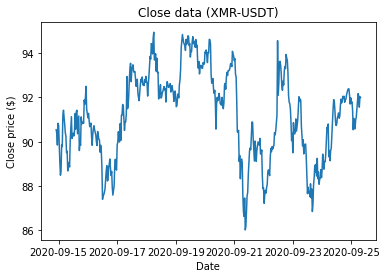

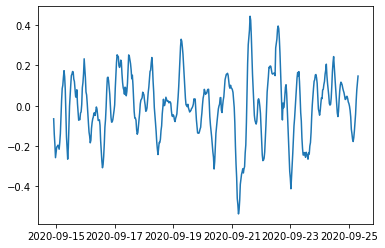

In [107]:
plt.plot(minute30.close[8060:8560])
plt.title("Close data (XMR-USDT)")
plt.xlabel("Date")
plt.ylabel("Close price ($)")
plt.show()
plt.plot(minute30.slope[8060:8560])
plt.show()

In [86]:
### Take the highest timeframe
print(f"[1h]: {hour4.size} candles")
print(f"[30m]: {minute30.size} candles")

[1h]: 17948 candles
[30m]: 35970 candles


In [28]:
print(f"----------- [1h] Size: {hour4.size} -----------")
print(f"Start: {hour4.index[0]}")
print(f"End: {hour4.index[-1]}")

print()
print(f"----------- [30m] Size: {minute30.size} -----------")
print(f"Start: {minute30.index[0]}")
print(f"End: {minute30.index[-1]}")

----------- [1h] Size: 8974 -----------
Start: 2020-03-31 06:00:00
End: 2021-04-09 16:00:00

----------- [30m] Size: 17985 -----------
Start: 2020-03-31 00:00:00
End: 2021-04-09 17:00:00


In [29]:
minute30Candles = minute30[(minute30.index <= hour4.index[-1]) & (hour4.index[0] <= minute30.index)]

print("----------- [30m] -----------")
print(f"Start: {minute30Candles.index[0]}")
print(f"End: {minute30Candles.index[-1]}")

----------- [30m] -----------
Start: 2020-03-31 06:00:00
End: 2021-04-09 16:00:00


In [30]:
hour4.shape

(8974, 1)

In [31]:
x1 = hour4.values #returns a numpy array
scaler4h = MinMaxScaler()
x_scaled4h = scaler4h.fit_transform(x1)
df4 = pd.DataFrame(x_scaled4h, index=hour4.index)

In [32]:
x2 = minute30.values #returns a numpy array
scaler30m = MinMaxScaler()
x_scaled30m = scaler30m.fit_transform(x2)
df30 = pd.DataFrame(x_scaled30m, index=minute30.index)

In [33]:
print(df4.head())

                            0
2020-03-31 06:00:00  0.562592
2020-03-31 07:00:00  0.559794
2020-03-31 08:00:00  0.556296
2020-03-31 09:00:00  0.551278
2020-03-31 10:00:00  0.544997


In [34]:
df30.head()

,0
2020-03-31 00:00:00,0.530658
2020-03-31 00:30:00,0.533827
2020-03-31 01:00:00,0.536656
2020-03-31 01:30:00,0.540386
2020-03-31 02:00:00,0.542056


In [38]:
def getSlopes(window):
#     print(window.head())
    slopes = window[0]
    X_train = slopes[0:30].to_numpy()
    Y_train = slopes[35]
    
    return X_train, Y_train

def combine_timeframe(t1, t2):
    X_train1, Y_train1 = getSlopes(t1)
    X_train2, Y_train2 = getSlopes(t2)
    
    comb_X_train = np.array([X_train1, X_train2])
    comb_Y_train = np.array(Y_train1)
    
    return comb_X_train, comb_Y_train


In [39]:
df4.shape

(8974, 1)

In [41]:


X = []
Y = []
for i in range(0, 8000):

    START, END = 0 + i, 36 + i # WINDOW SIZE, increment start and end by 1 loop and recalculate each window
    try:
        hour4Candles = df4[START:END]
        minute30Candles = df30[df30.index <= df4.index[END - 1]].tail(END)
    except Exception as e:
        print(e, END)

    X_train, Y_train = combine_timeframe(minute30Candles, hour4Candles)
    
    X.append(X_train)
    Y.append(Y_train)

X_train = np.array(X)
Y_train = np.array(Y)
# print(Y_train)

# scaler = MinMaxScaler()

# n = scaler.fit_transform(Y_train)


In [42]:
print(X_train.shape)
print(Y_train.shape)

Y_train[0]

(8000, 2, 30)
(8000,)


0.5466188524590163

In [43]:
X_te = []
Y_te = []
for i in range(8000,8500):

    START, END = 0 + i, 36 + i # WINDOW SIZE, increment start and end by 1 loop and recalculate each window
    
    try:
        hour4Candles = df4[START:END]
        minute30Candles = df30[df30.index <= df4.index[END - 1]].tail(END)
    except Exception as e:
        print(e, END)

    X_test, Y_test = combine_timeframe(minute30Candles, hour4Candles)
    
    X_te.append(X_test)
    Y_te.append(Y_test)

X_test = np.array(X_te)
Y_test = np.array(Y_te)

print(X_test.shape)
print(Y_test.shape)

(500, 2, 30)
(500,)


In [44]:
X_train.shape

(8000, 2, 30)

In [45]:
import keras
import tensorflow
from keras.layers import Bidirectional, CuDNNLSTM, Dropout, Dense, Activation, LSTM
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(
  LSTM(8, return_sequences=True,
  input_shape=(X_train.shape[1], X_train.shape[2]))
)
model.add(Dropout(rate=DROPOUT))

model.add(
  LSTM(16, return_sequences=True)
)
model.add(Dropout(rate=DROPOUT))

model.add(
  LSTM(32, return_sequences=True)
)

model.add(Dense(units=1))

model.add(Activation('linear'))

2022-05-01 17:12:16.029926: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-01 17:12:16.030218: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


In [67]:
BATCH_SIZE = 10

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

history = model.fit(
    X_train,
    Y_train,
    epochs=10,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_split=0.1
)

Epoch 1/10


2022-05-01 17:16:51.195249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-01 17:16:51.466543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-01 17:16:51.503256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-01 17:16:51.542860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-01 17:16:51.587269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  4/720 [..............................] - ETA: 16s - loss: 4.4724e-04  

2022-05-01 17:16:51.670882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-01 17:16:51.733913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


717/720 [============================>.] - ETA: 0s - loss: 2.9117e-04

2022-05-01 17:17:00.702299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-01 17:17:00.801271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-01 17:17:00.830930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-01 17:17:00.859954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


720/720 [==============================] - 11s 13ms/step - loss: 2.9186e-04 - val_loss: 6.9648e-04
Epoch 2/10
720/720 [==============================] - 9s 12ms/step - loss: 2.9052e-04 - val_loss: 8.1246e-04
Epoch 3/10
720/720 [==============================] - 9s 12ms/step - loss: 2.9146e-04 - val_loss: 6.9619e-04
Epoch 4/10
720/720 [==============================] - 9s 12ms/step - loss: 2.8979e-04 - val_loss: 7.0388e-04
Epoch 5/10
720/720 [==============================] - 9s 12ms/step - loss: 2.9311e-04 - val_loss: 7.0262e-04
Epoch 6/10
720/720 [==============================] - 9s 12ms/step - loss: 2.9153e-04 - val_loss: 7.0233e-04
Epoch 7/10
720/720 [==============================] - 9s 12ms/step - loss: 2.9590e-04 - val_loss: 6.9919e-04
Epoch 8/10
720/720 [==============================] - 9s 12ms/step - loss: 2.9500e-04 - val_loss: 7.2626e-04
Epoch 9/10
720/720 [==============================] - 9s 12ms/step - loss: 2.9196e-04 - val_loss: 6.9776e-04
Epoch 10/10
720/720 [========

In [68]:
y_hat = model.predict(X_test)
print(y_hat.shape)

2022-05-01 17:18:21.445044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-01 17:18:21.544742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-01 17:18:21.581542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-01 17:18:21.623170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


(500, 2, 1)


In [77]:
from sklearn.metrics import mean_squared_error



In [69]:
x = []
for i in range(len(y_hat)):
#     print(y_hat[i][0])
    x.append(y_hat[i][0][0])
    
x = np.array(x)

In [70]:
x

array([0.5280565 , 0.52805626, 0.5280564 , 0.52805597, 0.52805597,
       0.5280561 , 0.5280562 , 0.5280563 , 0.5280564 , 0.5280564 ,
       0.5280562 , 0.52805614, 0.52805626, 0.52805626, 0.5280568 ,
       0.52805674, 0.52805686, 0.5280569 , 0.52805704, 0.52805716,
       0.5280571 , 0.528057  , 0.52805674, 0.5280565 , 0.5280565 ,
       0.5280565 , 0.52805656, 0.52805656, 0.52805656, 0.52805656,
       0.5280567 , 0.5280568 , 0.5280569 , 0.52805704, 0.5280571 ,
       0.528057  , 0.52805704, 0.528057  , 0.52805686, 0.52805656,
       0.5280564 , 0.528056  , 0.5280559 , 0.5280559 , 0.5280559 ,
       0.5280561 , 0.5280561 , 0.528056  , 0.5280559 , 0.5280558 ,
       0.5280558 , 0.5280559 , 0.5280559 , 0.5280559 , 0.52805585,
       0.5280557 , 0.5280558 , 0.52805567, 0.5280557 , 0.52805567,
       0.52805537, 0.52805513, 0.5280551 , 0.5280551 , 0.528055  ,
       0.5280551 , 0.5280551 , 0.5280551 , 0.52805525, 0.5280553 ,
       0.5280556 , 0.5280558 , 0.5280561 , 0.5280563 , 0.52805

(500,)
(500,)
0.0005149382613839385


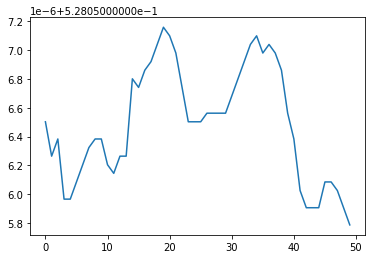

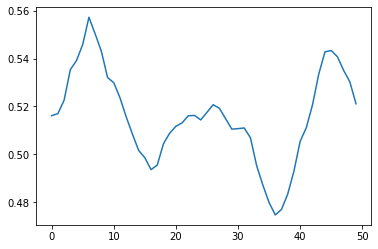

In [79]:
# t = y_hat[0]

# print(y_hat.shape[1])

print(x.shape)
print(Y_test.shape)

print(mean_squared_error(Y_test[0:50], x[0:50]))

plt.plot(x[0:50])
plt.show()
plt.plot(Y_test[0:50])
plt.show()

In [72]:
# plt.plot(y_hat[99])
# plt.plot(Y_train[99])


for i in range(20,30):
    y_hat_slope, y_hat_intercept, r, p, std_err = stats.linregress([int(i) for i in range(y_hat.shape[1])], x[i])
    Y_test_slope, Y_test_intercept, r, p, std_err = stats.linregress([int(i) for i in range(Y_test.shape[1])], Y_test[i])
    
    print(Y_test_slope, y_hat_slope)
    plt.plot(y_hat[i])
    plt.plot(Y_train[i])
    
    plt.show()

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2 and the array at index 1 has size 1

(500, 1)
(500, 1)


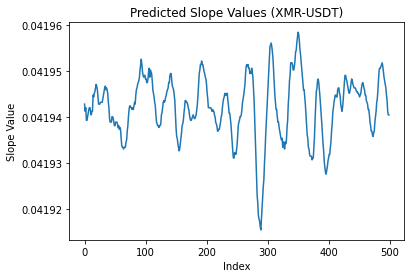

In [80]:
y_test_inverse = scaler30m.inverse_transform(Y_test.reshape(-1,1))
y_hat_inverse = scaler30m.inverse_transform(x.reshape(-1,1))

print(y_test_inverse.shape)
print(y_hat_inverse.shape)

plt.title("Predicted Slope Values (XMR-USDT)")
plt.xlabel("Index")
plt.ylabel("Slope Value")
plt.plot(y_hat_inverse)

In [76]:
mean_squared_error(y_test_inverse, y_hat_inverse)

0.02618747557474563

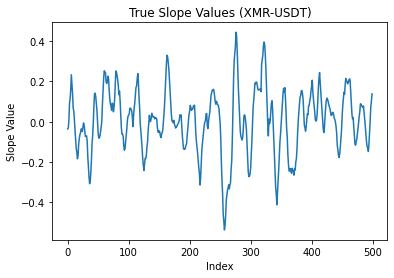

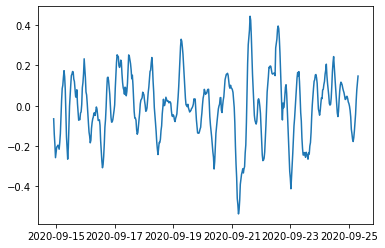

array([0.04194124], dtype=float32)

In [104]:
plt.title("True Slope Values (XMR-USDT)")
plt.xlabel("Index")
plt.ylabel("Slope Value")

plt.plot(y_test_inverse)
plt.show()
plt.plot(minute30.slope[8060:8560])
plt.show()
y_hat_inverse[1]

In [56]:
count = 0
for i in range(0,1):
    y_hat_slope, y_hat_intercept, r, p, std_err = stats.linregress([int(i) for i in range(y_hat.shape[1])], y_hat_inverse[i])
    Y_test_slope, Y_test_intercept, r, p, std_err = stats.linregress([int(i) for i in range(Y_test.shape[1])], y_test_inverse[i])
    
#     print(Y_test_slope, y_hat_slope)
    print(Y_test_slope, y_hat_slope)
    delta = Y_test_slope-y_hat_slope
    if(y_hat_slope > 0 and Y_test_slope > 0 or (y_hat_slope < 0 and Y_test_slope < 0)):
        count+=1
        plt.plot(y_hat_inverse[i])
        plt.plot(y_test_inverse[i])

        plt.show()
#     if(delta < 0.025 and delta > -0.025):
#         count+=1
#         plt.plot(y_hat_inverse[i])
#         plt.plot(y_test_inverse[i])

#         plt.show()
        
print(f"Answers right: {count/200}")

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2 and the array at index 1 has size 1

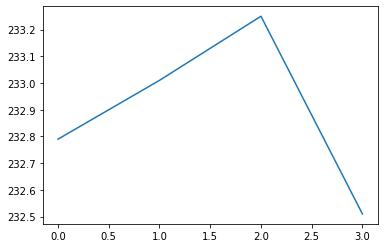

In [39]:
plt.plot(y_test[0])

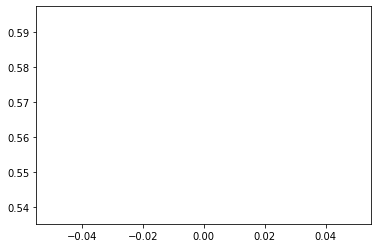

In [40]:
plt.plot(Y_test[2])

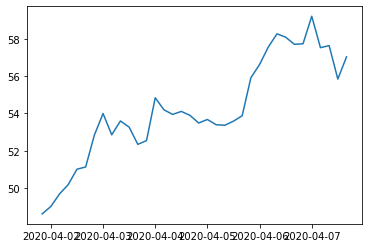

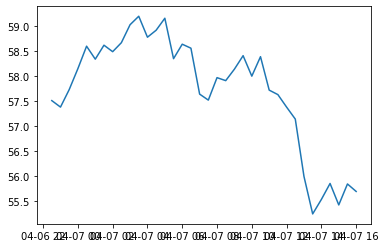

In [54]:
plt.plot(hour4Candles.close)
plt.show()

plt.plot(minute30Candles.close)
plt.show()

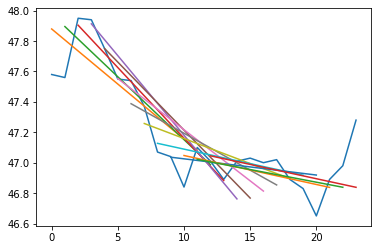

In [33]:
"""
    The slopes of the 24 candle window
"""

WINDOW = 24
SLIDING_WINDOW = 12

new_data = hour4
new_data.head()

# plt.plot(new_data.slope[12:])
# plt.xticks(rotation=45)
# plt.show()

plt.plot([i for i in range(0,WINDOW)], new_data.close[0:WINDOW])

for index in range(WINDOW-SLIDING_WINDOW+1):
    plt.plot([i for i in range(index,SLIDING_WINDOW+index)], [(new_data.slope[index+SLIDING_WINDOW - 1]*i)+new_data.intercept[index+SLIDING_WINDOW - 1] for i in range(SLIDING_WINDOW)])

                     close     slope  intercept
2020-03-31 00:00:00  47.58  0.058986  46.683077
2020-03-31 00:30:00  47.56  0.079755  46.618846
2020-03-31 01:00:00  47.95  0.098287  46.560256
2020-03-31 01:30:00  47.94  0.122727  46.511667
2020-03-31 02:00:00  47.75  0.133671  46.547308


ValueError: x and y must have same first dimension, but have shapes (24,) and (12,)

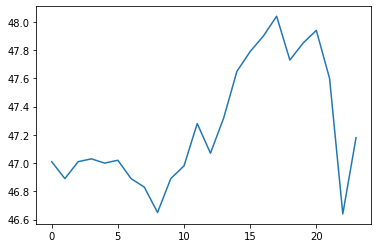

In [32]:
"""
    FOR PREDICTION
    The slope of the chart, 12 candles outside the window
"""
WINDOW_START = 12
WINDOW_END = 36
SLIDING_WINDOW = 12

new_data = hour4
print(new_data.head())


# print(new_data.slope[WINDOW_START:WINDOW_END])

# plt.plot(new_data.slope[12:])
# plt.xticks(rotation=45)
# plt.show()

plt.plot([i for i in range(0,WINDOW_END-WINDOW_START)], new_data.close[WINDOW_START:WINDOW_END])

plt.plot([i for i in range(0,WINDOW_END-WINDOW_START)], [(new_data.slope[WINDOW_START+SLIDING_WINDOW-1]*i)+new_data.intercept[WINDOW_START+SLIDING_WINDOW-1] for i in range(SLIDING_WINDOW)])

plt.show()
    
    

Text(0, 0.5, 'Close price ($)')

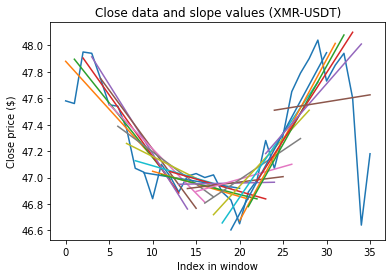

In [46]:
"""
    All slopes on chart
"""

WINDOW = 36
SLIDING_WINDOW = 12

new_data = hour4
new_data.head()

# plt.plot(new_data.slope[12:])
# plt.xticks(rotation=45)
# plt.show()

plt.plot([i for i in range(0,WINDOW)], new_data.close[0:WINDOW], label="Close data")

for index in range(WINDOW-SLIDING_WINDOW+1):
    plt.plot([i for i in range(index,SLIDING_WINDOW+index)], [(new_data.slope[index+SLIDING_WINDOW - 1]*i)+new_data.intercept[index+SLIDING_WINDOW - 1] for i in range(SLIDING_WINDOW)])
    
    
plt.title("Close data and slope values (XMR-USDT)")
plt.xlabel("Index in window")
plt.ylabel("Close price ($)")

In [18]:
for i in range(1,10):
    print(i)

1
2
3
4
5
6
7
8
9


0


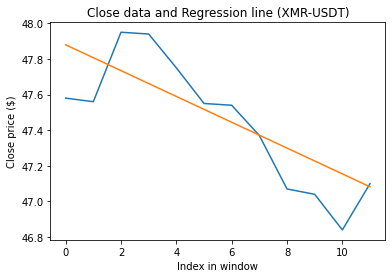

1


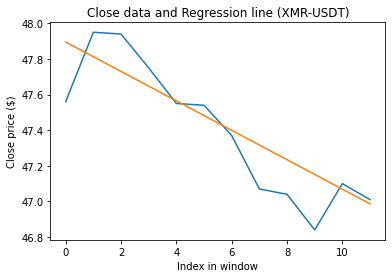

2


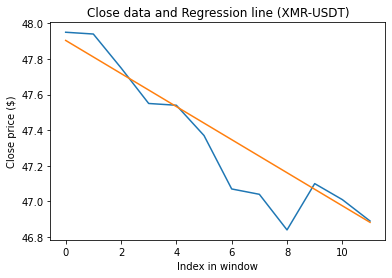

3


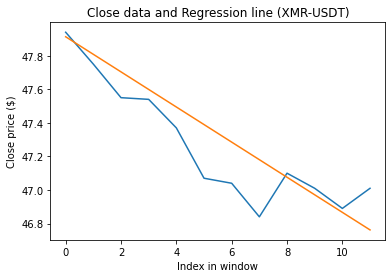

4


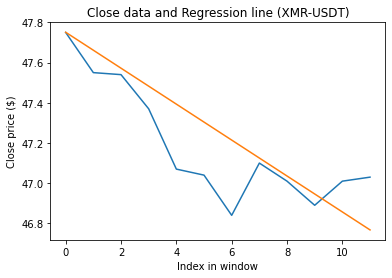

5


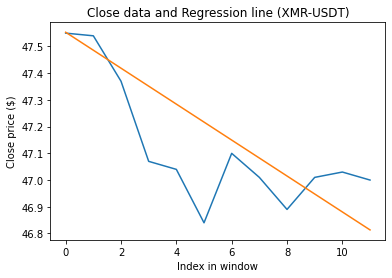

6


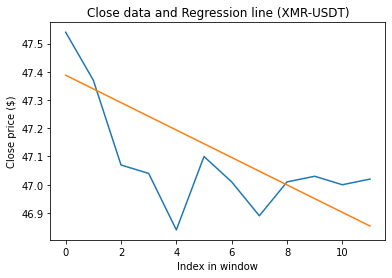

7


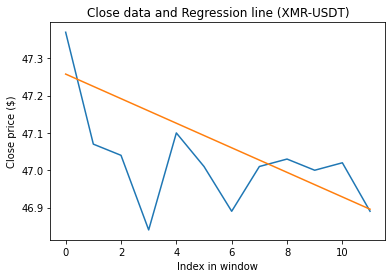

8


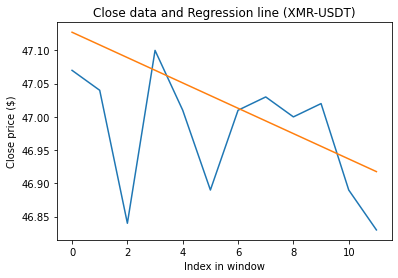

9


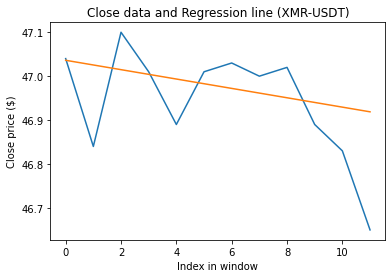

In [47]:


for index in range(0,10):
    print(index)
    plt.plot([i for i in range(0,12)], new_data.close[index:index+SLIDING_WINDOW])
    plt.plot([i for i in range(0,12)], [(new_data.slope[index+SLIDING_WINDOW-1]*i)+new_data.intercept[index+SLIDING_WINDOW-1] for i in range(SLIDING_WINDOW)])
    plt.title("Close data and Regression line (XMR-USDT)")
    plt.xlabel("Index in window")
    plt.ylabel("Close price ($)")
    plt.show()

compile time type static dispatch uses static type


run time type dynamic dispatch uses dynamic type

virtual function uses dynamic dispatch
non-virtual functio uses static dispatch

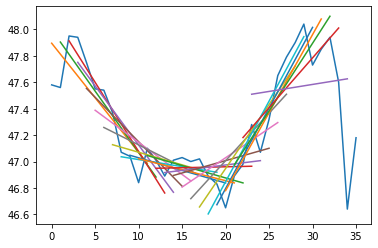

In [36]:
WINDOW = 36
SLIDING_WINDOW = 12

new_data = hour4
new_data.head()

slopes = []
for i in range(SLIDING_WINDOW, WINDOW):
    market_close_data = new_data.close[i-SLIDING_WINDOW:i]
    result = stats.linregress([int(i) for i in range(SLIDING_WINDOW)], market_close_data)
    slopes.append((result.slope, result.intercept))
    

plt.plot([i for i in range(0,36)], new_data.close[0:36])

for index in range(24):
    plt.plot([i for i in range(index,SLIDING_WINDOW+index)], [(slopes[index][0]*i)+slopes[index][1] for i in range(SLIDING_WINDOW)])

In [75]:
np.array([hour4Candles.slope.to_numpy(), minute30Candles.slope.to_numpy()])

array([[ 0.02101399,  0.08202797,  0.14153846,  0.19975524,  0.2698951 ,
         0.37706294,  0.42622378,  0.51153846,  0.60216783,  0.60590909,
         0.57940559,  0.55573427,  0.45566434,  0.36111888,  0.34541958,
         0.29493007,  0.22608392,  0.17444056,  0.09856643,  0.0648951 ,
         0.08671329,  0.04818182,  0.03835664,  0.0236014 , -0.02405594,
         0.00475524,  0.14146853,  0.27241259,  0.39587413,  0.48954545,
         0.53129371,  0.52898601,  0.5622028 ,  0.47947552,  0.3708042 ,
         0.1734965 ],
       [-0.23534965, -0.23073427, -0.16527972, -0.11237762, -0.01741259,
         0.05482517,  0.08353147,  0.11814685,  0.12314685,  0.14993007,
         0.16227273,  0.16055944,  0.14685315,  0.1284965 ,  0.1036014 ,
         0.05101399,  0.02433566,  0.01160839, -0.04804196, -0.09468531,
        -0.12223776, -0.14027972, -0.1277972 , -0.09097902, -0.0834965 ,
        -0.0491958 , -0.02604895, -0.03311189, -0.03157343, -0.03409091,
        -0.11272727, -0.21412

### new_data2 = calculate_slopes(m30, 12)
new_data2.head()

WINDOW = 36
SLIDING_WINDOW = 12

slopes = []
for i in range(SLIDING_WINDOW, WINDOW):
    market_close_data = new_data2.close[i-SLIDING_WINDOW:i]
    result = stats.linregress([int(i) for i in range(SLIDING_WINDOW)], market_close_data)
    slopes.append((result.slope, result.intercept))
#     plt.plot([i for i in range(SLIDING_WINDOW)],market_close_data)
#     plt.plot([i for i in range(SLIDING_WINDOW)], [(result.slope*i)+result.intercept for i in range(SLIDING_WINDOW)])
#     plt.show()
    
    
plt.plot([i for i in range(0,36)], new_data2.close[0:36])

for index in range(24):
    plt.plot([i for i in range(index,12+index)], [(slopes[index][0]*i)+slopes[index][1] for i in range(12)])